In [ ]:
#Srinitish Srinivasan
#21BAI1394

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


2024-03-21 21:40:13.524884: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-21 21:40:13.525191: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-21 21:40:13.525223: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-21 21:40:13.526031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-21 21:40:13.527297: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)

Found 1000 files belonging to 2 classes.


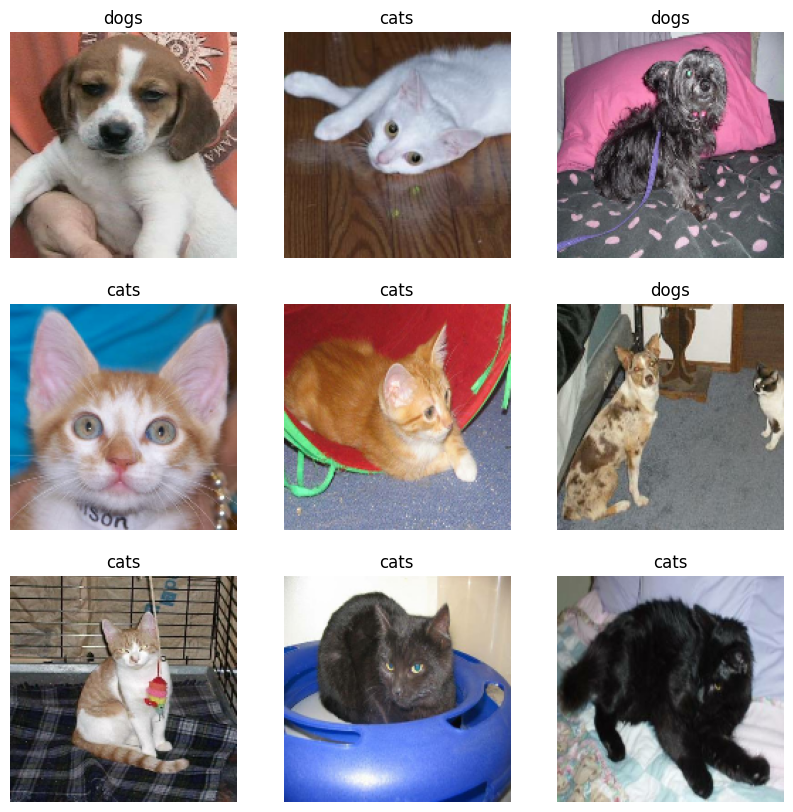

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print(
    "Number of validation batches: %d"
    % tf.data.experimental.cardinality(validation_dataset)
)
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
    ]
)

2024-03-21 21:40:20.376141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:40:20.482039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:40:20.502562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:40:20.520617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:40:20.538616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:40:20.556515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

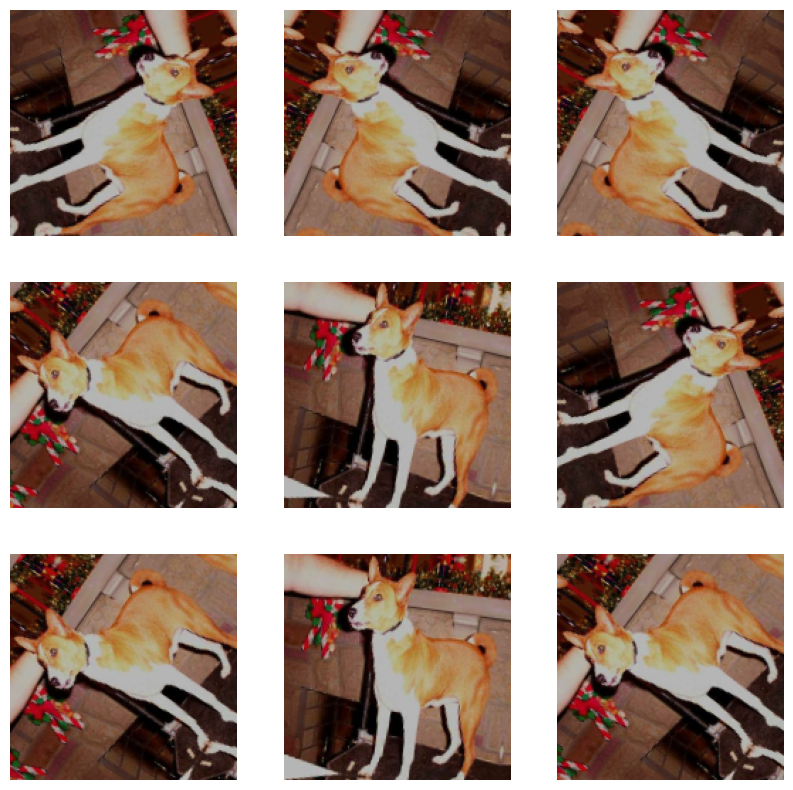

In [9]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.Rescaling(1.0 / 127.5, offset=-1)

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False, weights="imagenet"
)

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [14]:
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [20]:
len(model.trainable_variables)

2

In [21]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

2024-03-21 21:40:40.071364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 3s 66ms/step - loss: 0.8012 - accuracy: 0.5037


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.50


In [23]:
history = model.fit(
    train_dataset, epochs=initial_epochs, validation_data=validation_dataset
)

Epoch 1/10


2024-03-21 21:41:00.877673: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2024-03-21 21:41:01.087849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 4s - loss: 0.7634 - accuracy: 0.5417

2024-03-21 21:41:01.604388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:01.688319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:01.764926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 3s - loss: 0.7350 - accuracy: 0.5893

2024-03-21 21:41:01.830676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:01.892309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:01.955574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:02.019626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 3s - loss: 0.7405 - accuracy: 0.5594

2024-03-21 21:41:02.086665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:02.149287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:02.228386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 3s - loss: 0.7449 - accuracy: 0.5573

2024-03-21 21:41:02.314336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:02.416732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 3s - loss: 0.7386 - accuracy: 0.5458

2024-03-21 21:41:02.528218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:02.606623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:02.683671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.7414 - accuracy: 0.5469

2024-03-21 21:41:02.767500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:02.865162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:02.949936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.7265 - accuracy: 0.5625

2024-03-21 21:41:03.023714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:03.103038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:03.169615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.7218 - accuracy: 0.5750

2024-03-21 21:41:03.238944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:03.308333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:03.370811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.7187 - accuracy: 0.5759

2024-03-21 21:41:03.440649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:03.505734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:03.573595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.7152 - accuracy: 0.5802

2024-03-21 21:41:03.647140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:03.729599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:03.790867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.7070 - accuracy: 0.5901

2024-03-21 21:41:03.852759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:03.917707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:03.980392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:04.041713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.7004 - accuracy: 0.5929

2024-03-21 21:41:04.100841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:04.176431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:04.257884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.6960 - accuracy: 0.5983

2024-03-21 21:41:04.325794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:04.393815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:04.456808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:04.519293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.6880 - accuracy: 0.5986

2024-03-21 21:41:04.583670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:04.647205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:04.712212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:04.780477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.6804 - accuracy: 0.5989

2024-03-21 21:41:04.844303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:04.908023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:04.970850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:05.038549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.6788 - accuracy: 0.5996

2024-03-21 21:41:05.103891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:05.166397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:05.224230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:05.281941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.6687 - accuracy: 0.6107

2024-03-21 21:41:05.341167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:05.402353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:05.462211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:05.527923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.6646 - accuracy: 0.6112

2024-03-21 21:41:05.587955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:05.646560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:05.703345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:05.762531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.6628 - accuracy: 0.6124

2024-03-21 21:41:05.825105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 9s 101ms/step - loss: 0.6626 - accuracy: 0.6135 - val_loss: 0.5601 - val_accuracy: 0.6782
Epoch 2/10


2024-03-21 21:41:07.891592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 5s - loss: 0.5324 - accuracy: 0.7083

2024-03-21 21:41:08.147885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:08.237393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:08.309198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.4950 - accuracy: 0.7760

2024-03-21 21:41:08.383367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:08.475832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:08.579654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.5100 - accuracy: 0.7500

2024-03-21 21:41:08.707537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:08.777479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:08.841272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.5291 - accuracy: 0.7292

2024-03-21 21:41:08.912926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:09.000121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:09.082663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 3s - loss: 0.5270 - accuracy: 0.7333

2024-03-21 21:41:09.147744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:09.218544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:09.295239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.5235 - accuracy: 0.7237

2024-03-21 21:41:09.355023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:09.420040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:09.484424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:09.544402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 3s - loss: 0.5241 - accuracy: 0.7201

2024-03-21 21:41:09.605957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:09.669539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:09.728750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:09.786229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 2s - loss: 0.5250 - accuracy: 0.7234

2024-03-21 21:41:09.848350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:09.911874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:09.974819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:10.044377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.5213 - accuracy: 0.7198

2024-03-21 21:41:10.109169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:10.171233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:10.232525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:10.292455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.5134 - accuracy: 0.7233

2024-03-21 21:41:10.358357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:10.429737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:10.516329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.5125 - accuracy: 0.7270

2024-03-21 21:41:10.577888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:10.644612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:10.704029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:10.763010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.5128 - accuracy: 0.7269

2024-03-21 21:41:10.824869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:10.886482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:10.950536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:11.016151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.5162 - accuracy: 0.7229

2024-03-21 21:41:11.092590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:11.162170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:11.228760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 0s - loss: 0.5096 - accuracy: 0.7283

2024-03-21 21:41:11.300237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:11.365704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:11.426797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:11.488116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.5059 - accuracy: 0.7305

2024-03-21 21:41:11.559073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:11.630349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:11.689565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:11.749909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.5041 - accuracy: 0.7319

2024-03-21 21:41:11.833336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:11.907275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:11.972615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:12.032275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4998 - accuracy: 0.7377

2024-03-21 21:41:12.092631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:12.155581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:12.217915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:12.276395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4993 - accuracy: 0.7360

2024-03-21 21:41:12.334956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 92ms/step - loss: 0.4993 - accuracy: 0.7360 - val_loss: 0.4143 - val_accuracy: 0.7847
Epoch 3/10


2024-03-21 21:41:13.829021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 4s - loss: 0.4380 - accuracy: 0.7812

2024-03-21 21:41:14.090365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:14.188669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:14.251615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 3s - loss: 0.4693 - accuracy: 0.7812

2024-03-21 21:41:14.313871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:14.377971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:14.445363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:14.506058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 3s - loss: 0.4686 - accuracy: 0.7784

2024-03-21 21:41:14.584725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:14.660302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:14.728913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.4378 - accuracy: 0.8013

2024-03-21 21:41:14.790298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:14.853495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:14.920073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:14.984532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.4440 - accuracy: 0.7891

2024-03-21 21:41:15.056411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:15.232420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.4309 - accuracy: 0.7961

2024-03-21 21:41:15.317561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:15.398692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:15.464676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 2s - loss: 0.4285 - accuracy: 0.7948

2024-03-21 21:41:15.532886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:15.603030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:15.668889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:15.731898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 2s - loss: 0.4359 - accuracy: 0.7905

2024-03-21 21:41:15.806678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:15.873884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:15.942310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:16.006523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.4282 - accuracy: 0.7954

2024-03-21 21:41:16.082677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:16.155073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:16.217322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:16.282399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.4265 - accuracy: 0.7955

2024-03-21 21:41:16.344964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:16.414452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:16.485616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.4218 - accuracy: 0.7977

2024-03-21 21:41:16.545445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:16.619851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:16.685004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 1s - loss: 0.4256 - accuracy: 0.7914

2024-03-21 21:41:16.747714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:16.811957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:16.884965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.4250 - accuracy: 0.7940

2024-03-21 21:41:16.977243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:17.043878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:17.109597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:17.169626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.4281 - accuracy: 0.7899

2024-03-21 21:41:17.231894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:17.300725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:17.366320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.4251 - accuracy: 0.7912

2024-03-21 21:41:17.443858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:17.518776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:17.588169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.4197 - accuracy: 0.7948

2024-03-21 21:41:17.661616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:17.736384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:17.816379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.4174 - accuracy: 0.7933

2024-03-21 21:41:17.889384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:17.965284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:18.027164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:18.085380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.4133 - accuracy: 0.7961

2024-03-21 21:41:18.146075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:18.211083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:18.268507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:18.325018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.7970

2024-03-21 21:41:18.388443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 95ms/step - loss: 0.4147 - accuracy: 0.7970 - val_loss: 0.3217 - val_accuracy: 0.8515
Epoch 4/10


2024-03-21 21:41:19.978981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 4s - loss: 0.3748 - accuracy: 0.8229

2024-03-21 21:41:20.216814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:20.305587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:20.377025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 4s - loss: 0.3647 - accuracy: 0.8385

2024-03-21 21:41:20.450331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:20.541196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:20.618040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 4s - loss: 0.3653 - accuracy: 0.8333

2024-03-21 21:41:20.690899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:20.793489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:20.875476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 4s - loss: 0.3607 - accuracy: 0.8359

2024-03-21 21:41:20.958870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:21.061152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:21.150614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 4s - loss: 0.3579 - accuracy: 0.8438

2024-03-21 21:41:21.232437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:21.330821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:21.396724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 3s - loss: 0.3609 - accuracy: 0.8403

2024-03-21 21:41:21.472819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:21.555424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:21.621764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 3s - loss: 0.3551 - accuracy: 0.8438

2024-03-21 21:41:21.690052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:21.810024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:21.886864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.3588 - accuracy: 0.8385

2024-03-21 21:41:21.965941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:22.036340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:22.114730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 2s - loss: 0.3663 - accuracy: 0.8322

2024-03-21 21:41:22.185912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:22.270452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:22.355930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.3678 - accuracy: 0.8306

2024-03-21 21:41:22.435669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:22.521388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:22.583044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.3648 - accuracy: 0.8314

2024-03-21 21:41:22.642598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:22.709182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:22.790945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3588 - accuracy: 0.8359

2024-03-21 21:41:22.874058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:22.955775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:23.027867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 1s - loss: 0.3567 - accuracy: 0.8357

2024-03-21 21:41:23.106953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:23.193277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:23.268632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.3594 - accuracy: 0.8321

2024-03-21 21:41:23.352108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:23.419565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:23.487857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.3611 - accuracy: 0.8268

2024-03-21 21:41:23.559733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:23.622580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:23.687480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:23.747124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.3622 - accuracy: 0.8281

2024-03-21 21:41:23.809350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:23.870139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:23.937837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:23.998628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.3584 - accuracy: 0.8299

2024-03-21 21:41:24.066768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:24.125559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:24.181995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:24.249994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.3569 - accuracy: 0.8317

2024-03-21 21:41:24.330385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:24.434954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:24.512978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.3541 - accuracy: 0.8350

2024-03-21 21:41:24.577656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:24.642182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:24.702295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:24.767651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.8355

2024-03-21 21:41:24.846647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 106ms/step - loss: 0.3548 - accuracy: 0.8355 - val_loss: 0.2642 - val_accuracy: 0.8750
Epoch 5/10
 1/63 [..............................] - ETA: 11s - loss: 0.2418 - accuracy: 0.9062

2024-03-21 21:41:26.784697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:26.972514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.2972 - accuracy: 0.8750

2024-03-21 21:41:27.039236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:27.135442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:27.208840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.2942 - accuracy: 0.8750

2024-03-21 21:41:27.293786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:27.416009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 5s - loss: 0.2961 - accuracy: 0.8789

2024-03-21 21:41:27.523569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:27.717505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 5s - loss: 0.2880 - accuracy: 0.8750

2024-03-21 21:41:27.853650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:28.002432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 5s - loss: 0.2905 - accuracy: 0.8802

2024-03-21 21:41:28.135758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:28.252328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 5s - loss: 0.3026 - accuracy: 0.8711

2024-03-21 21:41:28.403398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:28.477651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:28.543411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 4s - loss: 0.2941 - accuracy: 0.8783

2024-03-21 21:41:28.612845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:28.678994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:28.753028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 4s - loss: 0.2910 - accuracy: 0.8810

2024-03-21 21:41:28.820801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:28.888989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:28.965360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 3s - loss: 0.2886 - accuracy: 0.8828

2024-03-21 21:41:29.033003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:29.124213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:29.201830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 3s - loss: 0.2857 - accuracy: 0.8819

2024-03-21 21:41:29.272980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:29.340871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:29.419282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2935 - accuracy: 0.8780

2024-03-21 21:41:29.489727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:29.559393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:29.630324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.2950 - accuracy: 0.8769

2024-03-21 21:41:29.692343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:29.765831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:29.839171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.3003 - accuracy: 0.8741

2024-03-21 21:41:29.920365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:30.027501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:30.120824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.3094 - accuracy: 0.8662

2024-03-21 21:41:30.231898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:30.315206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:30.388308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.3064 - accuracy: 0.8653

2024-03-21 21:41:30.474094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:30.571678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:30.659395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.3099 - accuracy: 0.8639

2024-03-21 21:41:30.747400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:30.837462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:30.934082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.3125 - accuracy: 0.8637

2024-03-21 21:41:31.015695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:31.119971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 1s - loss: 0.3150 - accuracy: 0.8603

2024-03-21 21:41:31.421565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:31.614667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 1s - loss: 0.3128 - accuracy: 0.8594

2024-03-21 21:41:31.693795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:31.790109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:31.854809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.3117 - accuracy: 0.8602

2024-03-21 21:41:31.930083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:31.994822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:32.116666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.3119 - accuracy: 0.8567

2024-03-21 21:41:32.215569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:32.299696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:32.358948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.3122 - accuracy: 0.8558

2024-03-21 21:41:32.436182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:32.503273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:32.569781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:32.627727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 114ms/step - loss: 0.3113 - accuracy: 0.8560 - val_loss: 0.2315 - val_accuracy: 0.8923
Epoch 6/10
 1/63 [..............................] - ETA: 9s - loss: 0.3080 - accuracy: 0.8438

2024-03-21 21:41:34.072344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:34.227015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 3s - loss: 0.2666 - accuracy: 0.8625

2024-03-21 21:41:34.289458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:34.357626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:34.420984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:34.487388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 3s - loss: 0.2845 - accuracy: 0.8646

2024-03-21 21:41:34.548251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:34.608498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:34.680022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:34.739707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.2847 - accuracy: 0.8726

2024-03-21 21:41:34.798816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:34.857190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:34.920881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:34.982386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 2s - loss: 0.2997 - accuracy: 0.8713

2024-03-21 21:41:35.048075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:35.119249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:35.182623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 2s - loss: 0.2965 - accuracy: 0.8717

2024-03-21 21:41:35.250953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:35.318772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:35.391169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 2s - loss: 0.2961 - accuracy: 0.8707

2024-03-21 21:41:35.459619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:35.539447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:35.618093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.2887 - accuracy: 0.8737

2024-03-21 21:41:35.694413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:35.765895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:35.832478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2906 - accuracy: 0.8739

2024-03-21 21:41:35.904196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:35.969881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:36.042061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2844 - accuracy: 0.8760

2024-03-21 21:41:36.118715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:36.206396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:36.271159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 1s - loss: 0.2789 - accuracy: 0.8732

2024-03-21 21:41:36.335426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:36.399658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:36.472943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 1s - loss: 0.2851 - accuracy: 0.8699

2024-03-21 21:41:36.572826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:36.657004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:36.724763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 1s - loss: 0.2911 - accuracy: 0.8636

2024-03-21 21:41:36.783682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:36.844756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:36.907472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:36.969329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 1s - loss: 0.2925 - accuracy: 0.8639

2024-03-21 21:41:37.032151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:37.103491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:37.169077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:37.230696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2926 - accuracy: 0.8639

2024-03-21 21:41:37.313984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:37.400051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:37.492759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 0s - loss: 0.2902 - accuracy: 0.8640

2024-03-21 21:41:37.608785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:37.723085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:37.805647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.2923 - accuracy: 0.8611

2024-03-21 21:41:38.072418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:38.167107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:38.239418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2919 - accuracy: 0.8610

2024-03-21 21:41:38.303386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:38.364482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:38.427901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:38.495784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2900 - accuracy: 0.8642

2024-03-21 21:41:38.579704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:38.646400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:38.727441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2897 - accuracy: 0.8625

2024-03-21 21:41:38.804073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 102ms/step - loss: 0.2897 - accuracy: 0.8625 - val_loss: 0.1994 - val_accuracy: 0.9183
Epoch 7/10
 1/63 [..............................] - ETA: 12s - loss: 0.2161 - accuracy: 0.9375

2024-03-21 21:41:40.552651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 4s - loss: 0.1948 - accuracy: 0.9271

2024-03-21 21:41:40.760963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:40.829825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:40.896323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 3s - loss: 0.2296 - accuracy: 0.9062

2024-03-21 21:41:40.971928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:41.040945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:41.105346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:41.163008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 3s - loss: 0.2416 - accuracy: 0.8938

2024-03-21 21:41:41.228656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:41.301774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:41.382409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.2356 - accuracy: 0.8990

2024-03-21 21:41:41.456281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:41.524839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:41.605221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.2320 - accuracy: 0.9043

2024-03-21 21:41:41.687739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:41.767172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:41.841090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.2329 - accuracy: 0.9046

2024-03-21 21:41:41.907286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:41.979832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:42.051831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 2s - loss: 0.2309 - accuracy: 0.9103

2024-03-21 21:41:42.117732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:42.181351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:42.241338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:42.298975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 2s - loss: 0.2305 - accuracy: 0.9075

2024-03-21 21:41:42.355020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:42.425036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:42.488765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2s - loss: 0.2321 - accuracy: 0.9031

2024-03-21 21:41:42.569554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:42.634507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:42.701071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:42.766083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 1s - loss: 0.2334 - accuracy: 0.9026

2024-03-21 21:41:42.829917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:42.890667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:42.954947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:43.022349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2409 - accuracy: 0.8997

2024-03-21 21:41:43.085494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:43.154858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:43.221668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:43.285913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.2450 - accuracy: 0.8951

2024-03-21 21:41:43.352818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:43.414385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:43.481572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:43.540165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2450 - accuracy: 0.8947

2024-03-21 21:41:43.607090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:43.668952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:43.729632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:43.790234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.2463 - accuracy: 0.8931

2024-03-21 21:41:43.851127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:43.912633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:43.971160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:44.038032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.2458 - accuracy: 0.8941

2024-03-21 21:41:44.101080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:44.159414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:44.217238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:44.280586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 0s - loss: 0.2494 - accuracy: 0.8912

2024-03-21 21:41:44.343233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:44.405418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:44.465288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:44.526926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2482 - accuracy: 0.8911

2024-03-21 21:41:44.589250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:44.650060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:44.712388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:44.773665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 89ms/step - loss: 0.2481 - accuracy: 0.8915 - val_loss: 0.1824 - val_accuracy: 0.9270
Epoch 8/10
 1/63 [..............................] - ETA: 12s - loss: 0.2334 - accuracy: 0.8750

2024-03-21 21:41:46.278599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:46.478084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 4s - loss: 0.2605 - accuracy: 0.8906

2024-03-21 21:41:46.555624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:46.622635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:46.698597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 4s - loss: 0.2364 - accuracy: 0.8973

2024-03-21 21:41:46.766367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:46.844127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:46.909346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 3s - loss: 0.2424 - accuracy: 0.8906

2024-03-21 21:41:46.976316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:47.056623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:47.132397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 3s - loss: 0.2363 - accuracy: 0.8973

2024-03-21 21:41:47.209973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:47.280651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:47.349271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 3s - loss: 0.2525 - accuracy: 0.8915

2024-03-21 21:41:47.415504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:47.476196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:47.539662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:47.606852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 2s - loss: 0.2405 - accuracy: 0.8988

2024-03-21 21:41:47.672721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:47.740870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:47.804178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:47.869954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 2s - loss: 0.2445 - accuracy: 0.8971

2024-03-21 21:41:48.055101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:48.130987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:48.202290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 2s - loss: 0.2469 - accuracy: 0.8951

2024-03-21 21:41:48.271624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:48.341266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:48.409590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2406 - accuracy: 0.9022

2024-03-21 21:41:48.475824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:48.542791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:48.609315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:48.673444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 2s - loss: 0.2393 - accuracy: 0.8973

2024-03-21 21:41:48.753533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:48.817102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:48.886231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 1s - loss: 0.2391 - accuracy: 0.8988

2024-03-21 21:41:48.956819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:49.019604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:49.084591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:49.147445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.2475 - accuracy: 0.8943

2024-03-21 21:41:49.212051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:49.283948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:49.349800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 1s - loss: 0.2463 - accuracy: 0.8956

2024-03-21 21:41:49.418403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:49.485707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:49.556086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 1s - loss: 0.2431 - accuracy: 0.8976

2024-03-21 21:41:49.643691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:49.755437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:49.843130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 0s - loss: 0.2405 - accuracy: 0.8975

2024-03-21 21:41:49.940458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:50.026184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:50.100721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 0s - loss: 0.2436 - accuracy: 0.8935

2024-03-21 21:41:50.166185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:50.227429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:50.292558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:50.354230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 0s - loss: 0.2416 - accuracy: 0.8953

2024-03-21 21:41:50.421746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:50.502079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:50.567375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 0s - loss: 0.2395 - accuracy: 0.8981

2024-03-21 21:41:50.631077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:50.690618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:50.756514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:50.824783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.8980

2024-03-21 21:41:50.899560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 97ms/step - loss: 0.2405 - accuracy: 0.8980 - val_loss: 0.1680 - val_accuracy: 0.9344
Epoch 9/10


2024-03-21 21:41:52.503373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 3s - loss: 0.1967 - accuracy: 0.9062

2024-03-21 21:41:52.743562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:52.814795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:52.874888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:52.943213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 3s - loss: 0.2103 - accuracy: 0.9141

2024-03-21 21:41:53.004448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:53.068746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:53.128710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:53.189787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 3s - loss: 0.2171 - accuracy: 0.9141

2024-03-21 21:41:53.256965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:53.318294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:53.385081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:53.443750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 2s - loss: 0.2195 - accuracy: 0.9062

2024-03-21 21:41:53.505794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:53.564013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:53.627501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:53.687102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 2s - loss: 0.2198 - accuracy: 0.9141

2024-03-21 21:41:53.750146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:53.814991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:53.876281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:53.941697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 2s - loss: 0.2285 - accuracy: 0.9022

2024-03-21 21:41:54.007449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:54.077443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:54.142935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 2s - loss: 0.2349 - accuracy: 0.8970

2024-03-21 21:41:54.217067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:54.286495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:54.354982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:54.417010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2s - loss: 0.2291 - accuracy: 0.9002

2024-03-21 21:41:54.485645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:54.551883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:54.610021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:54.674239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 1s - loss: 0.2276 - accuracy: 0.9000

2024-03-21 21:41:54.744470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:54.815480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:54.881934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:54.941576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 1s - loss: 0.2220 - accuracy: 0.9038

2024-03-21 21:41:55.004412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:55.072233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:55.133376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:55.192656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 1s - loss: 0.2264 - accuracy: 0.9026

2024-03-21 21:41:55.254548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:55.315038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:55.381032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:55.444580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2269 - accuracy: 0.9022

2024-03-21 21:41:55.509294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:55.575825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:55.658488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 0s - loss: 0.2259 - accuracy: 0.9024

2024-03-21 21:41:55.741105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:55.841497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:55.925860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.2292 - accuracy: 0.9021

2024-03-21 21:41:56.033544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:56.104191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:56.173624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 0s - loss: 0.2276 - accuracy: 0.9028

2024-03-21 21:41:56.239287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:56.308289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:56.373098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 0s - loss: 0.2252 - accuracy: 0.9025

2024-03-21 21:41:56.447392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:56.510856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:56.581603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2273 - accuracy: 0.9012

2024-03-21 21:41:56.648963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:56.720993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:56.784315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.8995

2024-03-21 21:41:56.849714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 6s 97ms/step - loss: 0.2289 - accuracy: 0.8995 - val_loss: 0.1473 - val_accuracy: 0.9431
Epoch 10/10
 1/63 [..............................] - ETA: 11s - loss: 0.2031 - accuracy: 0.9062

2024-03-21 21:41:58.735837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:58.927493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 5s - loss: 0.2258 - accuracy: 0.8828

2024-03-21 21:41:59.034885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:59.132282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:59.201708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 4s - loss: 0.2077 - accuracy: 0.8984

2024-03-21 21:41:59.300444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:59.369004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:59.434613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 4s - loss: 0.1942 - accuracy: 0.9094

2024-03-21 21:41:59.502154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:59.574422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:59.641142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 3s - loss: 0.2055 - accuracy: 0.9087

2024-03-21 21:41:59.718950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:59.788957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:41:59.868477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 3s - loss: 0.2126 - accuracy: 0.9043

2024-03-21 21:41:59.948562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:00.038105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:00.115605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 3s - loss: 0.2077 - accuracy: 0.9095

2024-03-21 21:42:00.188863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:00.283099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:00.351389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 3s - loss: 0.2078 - accuracy: 0.9105

2024-03-21 21:42:00.436662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:00.523384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:00.590564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 2s - loss: 0.2042 - accuracy: 0.9112

2024-03-21 21:42:00.650465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:00.735944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:00.826808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 2s - loss: 0.2070 - accuracy: 0.9084

2024-03-21 21:42:00.907626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:00.982756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:01.047240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:01.109331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2s - loss: 0.2071 - accuracy: 0.9110

2024-03-21 21:42:01.172019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:01.240271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:01.309907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2s - loss: 0.2095 - accuracy: 0.9099

2024-03-21 21:42:01.384712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:01.466399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 2s - loss: 0.2091 - accuracy: 0.9097

2024-03-21 21:42:01.679811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:01.878349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 2s - loss: 0.2140 - accuracy: 0.9071

2024-03-21 21:42:02.063851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:02.135549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:02.205741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 1s - loss: 0.2136 - accuracy: 0.9085

2024-03-21 21:42:02.299405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:02.374395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:02.448621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 1s - loss: 0.2121 - accuracy: 0.9083

2024-03-21 21:42:02.514829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:02.583656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:02.649622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 1s - loss: 0.2127 - accuracy: 0.9076

2024-03-21 21:42:02.717975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:02.779001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:02.848463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 1s - loss: 0.2144 - accuracy: 0.9038

2024-03-21 21:42:02.993140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 0s - loss: 0.2106 - accuracy: 0.9057

2024-03-21 21:42:03.195495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:03.275116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:03.339978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 0s - loss: 0.2101 - accuracy: 0.9057

2024-03-21 21:42:03.403418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:03.470722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:03.533559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:03.592071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 0s - loss: 0.2134 - accuracy: 0.9047

2024-03-21 21:42:03.654817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:03.722132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:03.782844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:03.841600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.2140 - accuracy: 0.9032

2024-03-21 21:42:03.899941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-03-21 21:42:03.959080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 7s 107ms/step - loss: 0.2140 - accuracy: 0.9035 - val_loss: 0.1338 - val_accuracy: 0.9579


In [24]:
base_model.trainable = True

In [25]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
    metrics=["accuracy"],
)

In [26]:
len(model.trainable_variables)

158

In [27]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
)

Epoch 10/20


2024-03-21 21:42:56.300450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 18:08 - loss: 0.1119 - accuracy: 0.9688

2024-03-21 21:43:08.198817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 55s - loss: 0.1358 - accuracy: 0.9688  

2024-03-21 21:43:09.128540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 49s - loss: 0.1782 - accuracy: 0.9375

2024-03-21 21:43:09.839758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 43s - loss: 0.2076 - accuracy: 0.9141

2024-03-21 21:43:10.433288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 42s - loss: 0.2124 - accuracy: 0.8938

2024-03-21 21:43:11.127348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 38s - loss: 0.1963 - accuracy: 0.9062

2024-03-21 21:43:11.621836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 36s - loss: 0.1814 - accuracy: 0.9196

2024-03-21 21:43:12.111822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 34s - loss: 0.1856 - accuracy: 0.9180

2024-03-21 21:43:12.618118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 33s - loss: 0.1811 - accuracy: 0.9167

2024-03-21 21:43:13.224580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 32s - loss: 0.1794 - accuracy: 0.9156

2024-03-21 21:43:13.755538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 31s - loss: 0.1724 - accuracy: 0.9205

2024-03-21 21:43:14.337276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 31s - loss: 0.1751 - accuracy: 0.9193

2024-03-21 21:43:14.919214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 31s - loss: 0.1734 - accuracy: 0.9207

2024-03-21 21:43:15.712454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 30s - loss: 0.1766 - accuracy: 0.9219

2024-03-21 21:43:16.256037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 29s - loss: 0.1739 - accuracy: 0.9250

2024-03-21 21:43:16.905709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 29s - loss: 0.1831 - accuracy: 0.9219

2024-03-21 21:43:17.713323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 29s - loss: 0.1799 - accuracy: 0.9265

2024-03-21 21:43:18.611865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 29s - loss: 0.1740 - accuracy: 0.9288

2024-03-21 21:43:19.357098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 28s - loss: 0.1713 - accuracy: 0.9293

2024-03-21 21:43:19.945878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 27s - loss: 0.1719 - accuracy: 0.9297

2024-03-21 21:43:20.475123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 26s - loss: 0.1716 - accuracy: 0.9301

2024-03-21 21:43:20.967451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 25s - loss: 0.1670 - accuracy: 0.9304

2024-03-21 21:43:21.452847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 24s - loss: 0.1650 - accuracy: 0.9307

2024-03-21 21:43:21.939518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 24s - loss: 0.1601 - accuracy: 0.9336

2024-03-21 21:43:22.430789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 23s - loss: 0.1582 - accuracy: 0.9337

2024-03-21 21:43:23.052606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 22s - loss: 0.1535 - accuracy: 0.9351

2024-03-21 21:43:23.570362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 22s - loss: 0.1511 - accuracy: 0.9363

2024-03-21 21:43:24.093147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 21s - loss: 0.1476 - accuracy: 0.9386

2024-03-21 21:43:24.652942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 20s - loss: 0.1504 - accuracy: 0.9375

2024-03-21 21:43:25.351296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 20s - loss: 0.1483 - accuracy: 0.9385

2024-03-21 21:43:26.119884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 19s - loss: 0.1459 - accuracy: 0.9405

2024-03-21 21:43:26.601333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 18s - loss: 0.1456 - accuracy: 0.9404

2024-03-21 21:43:27.113369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 18s - loss: 0.1527 - accuracy: 0.9384

2024-03-21 21:43:27.618180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 17s - loss: 0.1522 - accuracy: 0.9384

2024-03-21 21:43:28.109323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 17s - loss: 0.1529 - accuracy: 0.9384

2024-03-21 21:43:28.967286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 16s - loss: 0.1514 - accuracy: 0.9384

2024-03-21 21:43:29.502853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 15s - loss: 0.1499 - accuracy: 0.9383

2024-03-21 21:43:30.024362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 15s - loss: 0.1483 - accuracy: 0.9391

2024-03-21 21:43:30.641978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 14s - loss: 0.1485 - accuracy: 0.9391

2024-03-21 21:43:31.133917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 13s - loss: 0.1478 - accuracy: 0.9391

2024-03-21 21:43:31.752603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 13s - loss: 0.1485 - accuracy: 0.9390

2024-03-21 21:43:32.303194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 12s - loss: 0.1489 - accuracy: 0.9382

2024-03-21 21:43:32.964216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 12s - loss: 0.1485 - accuracy: 0.9382

2024-03-21 21:43:33.470523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 11s - loss: 0.1525 - accuracy: 0.9368

2024-03-21 21:43:33.990732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 10s - loss: 0.1524 - accuracy: 0.9361

2024-03-21 21:43:34.516158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 10s - loss: 0.1544 - accuracy: 0.9355

2024-03-21 21:43:35.086149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 9s - loss: 0.1583 - accuracy: 0.9342 

2024-03-21 21:43:35.651334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 8s - loss: 0.1560 - accuracy: 0.9355

2024-03-21 21:43:36.162623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 8s - loss: 0.1566 - accuracy: 0.9356

2024-03-21 21:43:36.768943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 7s - loss: 0.1568 - accuracy: 0.9350

2024-03-21 21:43:37.411007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 7s - loss: 0.1570 - accuracy: 0.9338

2024-03-21 21:43:37.981502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 6s - loss: 0.1579 - accuracy: 0.9327

2024-03-21 21:43:38.942623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 6s - loss: 0.1588 - accuracy: 0.9316

2024-03-21 21:43:40.105019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 5s - loss: 0.1580 - accuracy: 0.9317

2024-03-21 21:43:41.010625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 4s - loss: 0.1570 - accuracy: 0.9324

2024-03-21 21:43:41.658481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 4s - loss: 0.1573 - accuracy: 0.9325

2024-03-21 21:43:42.199274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 3s - loss: 0.1566 - accuracy: 0.9331

2024-03-21 21:43:42.758088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 3s - loss: 0.1569 - accuracy: 0.9327

2024-03-21 21:43:43.405565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 2s - loss: 0.1576 - accuracy: 0.9327

2024-03-21 21:43:44.235586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.1557 - accuracy: 0.9339

2024-03-21 21:43:45.125252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 1s - loss: 0.1559 - accuracy: 0.9339

2024-03-21 21:43:45.845873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1562 - accuracy: 0.9340

2024-03-21 21:43:46.445063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 63s 733ms/step - loss: 0.1566 - accuracy: 0.9340 - val_loss: 0.0657 - val_accuracy: 0.9752
Epoch 11/20


2024-03-21 21:43:53.669313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 1:24 - loss: 0.0690 - accuracy: 0.9688

2024-03-21 21:43:55.047705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 1:52 - loss: 0.0549 - accuracy: 0.9688

2024-03-21 21:43:56.872184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 1:27 - loss: 0.0871 - accuracy: 0.9479

2024-03-21 21:43:57.935836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 1:13 - loss: 0.1545 - accuracy: 0.9297

2024-03-21 21:43:58.749275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 1:05 - loss: 0.1309 - accuracy: 0.9438

2024-03-21 21:43:59.576126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 1:17 - loss: 0.1181 - accuracy: 0.9479

2024-03-21 21:44:01.838083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 1:19 - loss: 0.1095 - accuracy: 0.9509

2024-03-21 21:44:03.588916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 1:16 - loss: 0.1167 - accuracy: 0.9492

2024-03-21 21:44:04.765927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 1:10 - loss: 0.1289 - accuracy: 0.9479

2024-03-21 21:44:05.449469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 1:04 - loss: 0.1239 - accuracy: 0.9531

2024-03-21 21:44:06.042869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 1:01 - loss: 0.1176 - accuracy: 0.9545

2024-03-21 21:44:06.825458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 59s - loss: 0.1223 - accuracy: 0.9505 

2024-03-21 21:44:07.942010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 57s - loss: 0.1178 - accuracy: 0.9519

2024-03-21 21:44:08.929950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 57s - loss: 0.1162 - accuracy: 0.9531

2024-03-21 21:44:10.597544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 59s - loss: 0.1191 - accuracy: 0.9500

2024-03-21 21:44:12.333769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 57s - loss: 0.1191 - accuracy: 0.9492

2024-03-21 21:44:13.420621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 57s - loss: 0.1190 - accuracy: 0.9504

2024-03-21 21:44:15.136033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 56s - loss: 0.1138 - accuracy: 0.9531

2024-03-21 21:44:16.309541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 54s - loss: 0.1145 - accuracy: 0.9539

2024-03-21 21:44:17.133070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 51s - loss: 0.1139 - accuracy: 0.9547

2024-03-21 21:44:17.698178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 48s - loss: 0.1097 - accuracy: 0.9568

2024-03-21 21:44:18.246989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 46s - loss: 0.1092 - accuracy: 0.9560

2024-03-21 21:44:18.887016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 44s - loss: 0.1096 - accuracy: 0.9552

2024-03-21 21:44:19.462955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 42s - loss: 0.1078 - accuracy: 0.9557

2024-03-21 21:44:20.163419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 41s - loss: 0.1073 - accuracy: 0.9550

2024-03-21 21:44:21.406486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 40s - loss: 0.1117 - accuracy: 0.9531

2024-03-21 21:44:22.115455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 38s - loss: 0.1174 - accuracy: 0.9514

2024-03-21 21:44:22.678996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 36s - loss: 0.1152 - accuracy: 0.9531

2024-03-21 21:44:23.359047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 35s - loss: 0.1115 - accuracy: 0.9547

2024-03-21 21:44:24.107271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 33s - loss: 0.1163 - accuracy: 0.9531

2024-03-21 21:44:24.789542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 32s - loss: 0.1131 - accuracy: 0.9546

2024-03-21 21:44:25.364476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 30s - loss: 0.1159 - accuracy: 0.9531

2024-03-21 21:44:25.999180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 29s - loss: 0.1149 - accuracy: 0.9527

2024-03-21 21:44:26.578074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 28s - loss: 0.1148 - accuracy: 0.9522

2024-03-21 21:44:27.184663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 27s - loss: 0.1176 - accuracy: 0.9518

2024-03-21 21:44:27.840275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 25s - loss: 0.1171 - accuracy: 0.9523

2024-03-21 21:44:28.380387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 24s - loss: 0.1163 - accuracy: 0.9527

2024-03-21 21:44:28.975279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 23s - loss: 0.1180 - accuracy: 0.9498

2024-03-21 21:44:29.550235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 22s - loss: 0.1184 - accuracy: 0.9495

2024-03-21 21:44:30.125034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 21s - loss: 0.1228 - accuracy: 0.9477

2024-03-21 21:44:30.856191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 20s - loss: 0.1238 - accuracy: 0.9466

2024-03-21 21:44:31.636571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 19s - loss: 0.1255 - accuracy: 0.9464

2024-03-21 21:44:32.478845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 18s - loss: 0.1264 - accuracy: 0.9469

2024-03-21 21:44:33.210152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 17s - loss: 0.1274 - accuracy: 0.9460

2024-03-21 21:44:33.864888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 16s - loss: 0.1259 - accuracy: 0.9465

2024-03-21 21:44:34.521439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 15s - loss: 0.1257 - accuracy: 0.9470

2024-03-21 21:44:35.133988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 14s - loss: 0.1270 - accuracy: 0.9461

2024-03-21 21:44:35.870653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 13s - loss: 0.1282 - accuracy: 0.9460

2024-03-21 21:44:36.726815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 12s - loss: 0.1298 - accuracy: 0.9452

2024-03-21 21:44:37.412757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 11s - loss: 0.1315 - accuracy: 0.9444

2024-03-21 21:44:38.060716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 10s - loss: 0.1305 - accuracy: 0.9449

2024-03-21 21:44:38.993432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 10s - loss: 0.1309 - accuracy: 0.9447

2024-03-21 21:44:42.433173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 9s - loss: 0.1324 - accuracy: 0.9446 

2024-03-21 21:44:44.138260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 8s - loss: 0.1306 - accuracy: 0.9456

2024-03-21 21:44:44.787921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 7s - loss: 0.1308 - accuracy: 0.9455

2024-03-21 21:44:45.298582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 6s - loss: 0.1297 - accuracy: 0.9453

2024-03-21 21:44:45.810950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 5s - loss: 0.1283 - accuracy: 0.9457

2024-03-21 21:44:46.316062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 4s - loss: 0.1275 - accuracy: 0.9461

2024-03-21 21:44:46.803447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 3s - loss: 0.1288 - accuracy: 0.9454

2024-03-21 21:44:47.330947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 2s - loss: 0.1272 - accuracy: 0.9464

2024-03-21 21:44:47.816438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 1s - loss: 0.1262 - accuracy: 0.9472

2024-03-21 21:44:48.273419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.1263 - accuracy: 0.9466

2024-03-21 21:44:48.784281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 59s 926ms/step - loss: 0.1255 - accuracy: 0.9470 - val_loss: 0.0596 - val_accuracy: 0.9802
Epoch 12/20


2024-03-21 21:44:52.426663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 1:04 - loss: 0.0461 - accuracy: 0.9688

2024-03-21 21:44:53.481902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 34s - loss: 0.0916 - accuracy: 0.9531 

2024-03-21 21:44:54.052806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 36s - loss: 0.0685 - accuracy: 0.9688

2024-03-21 21:44:54.714365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 36s - loss: 0.0657 - accuracy: 0.9688

2024-03-21 21:44:55.320313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 34s - loss: 0.0787 - accuracy: 0.9563

2024-03-21 21:44:55.878669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 34s - loss: 0.0715 - accuracy: 0.9635

2024-03-21 21:44:56.477106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 32s - loss: 0.0793 - accuracy: 0.9598

2024-03-21 21:44:56.987365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 32s - loss: 0.0813 - accuracy: 0.9570

2024-03-21 21:44:57.552786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 31s - loss: 0.0772 - accuracy: 0.9583

2024-03-21 21:44:58.076730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 30s - loss: 0.0793 - accuracy: 0.9594

2024-03-21 21:44:58.649412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 29s - loss: 0.0756 - accuracy: 0.9631

2024-03-21 21:44:59.161795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 28s - loss: 0.0789 - accuracy: 0.9635

2024-03-21 21:44:59.711202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 28s - loss: 0.0938 - accuracy: 0.9567

2024-03-21 21:45:00.220577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 27s - loss: 0.1016 - accuracy: 0.9554

2024-03-21 21:45:00.721343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 27s - loss: 0.1066 - accuracy: 0.9542

2024-03-21 21:45:01.413155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 26s - loss: 0.1006 - accuracy: 0.9570

2024-03-21 21:45:02.058770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 26s - loss: 0.0968 - accuracy: 0.9596

2024-03-21 21:45:02.757060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 27s - loss: 0.0943 - accuracy: 0.9618

2024-03-21 21:45:03.710064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 27s - loss: 0.0922 - accuracy: 0.9638

2024-03-21 21:45:04.842048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 31s - loss: 0.0937 - accuracy: 0.9641

2024-03-21 21:45:07.419704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 34s - loss: 0.0921 - accuracy: 0.9643

2024-03-21 21:45:09.778636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 35s - loss: 0.0901 - accuracy: 0.9645

2024-03-21 21:45:11.911013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 36s - loss: 0.0892 - accuracy: 0.9647

2024-03-21 21:45:13.620079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 35s - loss: 0.0922 - accuracy: 0.9635

2024-03-21 21:45:14.343719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 34s - loss: 0.0932 - accuracy: 0.9638

2024-03-21 21:45:15.025655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 33s - loss: 0.0899 - accuracy: 0.9651

2024-03-21 21:45:15.799955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 32s - loss: 0.0869 - accuracy: 0.9664

2024-03-21 21:45:16.705878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 30s - loss: 0.0877 - accuracy: 0.9654

2024-03-21 21:45:17.238269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 30s - loss: 0.0922 - accuracy: 0.9644

2024-03-21 21:45:18.546025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 33s - loss: 0.0904 - accuracy: 0.9656

2024-03-21 21:45:22.885020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 34s - loss: 0.0919 - accuracy: 0.9657

2024-03-21 21:45:25.494297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 33s - loss: 0.0899 - accuracy: 0.9668

2024-03-21 21:45:26.497630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 31s - loss: 0.0882 - accuracy: 0.9669

2024-03-21 21:45:27.022979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 30s - loss: 0.0882 - accuracy: 0.9669

2024-03-21 21:45:27.750792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 28s - loss: 0.0967 - accuracy: 0.9634

2024-03-21 21:45:28.310359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 27s - loss: 0.0960 - accuracy: 0.9635

2024-03-21 21:45:28.886339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 26s - loss: 0.0942 - accuracy: 0.9645

2024-03-21 21:45:29.881796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 25s - loss: 0.0954 - accuracy: 0.9638

2024-03-21 21:45:30.790964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 24s - loss: 0.0970 - accuracy: 0.9631

2024-03-21 21:45:31.529529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 22s - loss: 0.0960 - accuracy: 0.9633

2024-03-21 21:45:32.434861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 21s - loss: 0.0958 - accuracy: 0.9634

2024-03-21 21:45:32.968952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 20s - loss: 0.0958 - accuracy: 0.9635

2024-03-21 21:45:33.751821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 19s - loss: 0.0938 - accuracy: 0.9644

2024-03-21 21:45:34.336318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 18s - loss: 0.0937 - accuracy: 0.9645

2024-03-21 21:45:36.596056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 18s - loss: 0.0976 - accuracy: 0.9618

2024-03-21 21:45:38.025129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 17s - loss: 0.0981 - accuracy: 0.9613

2024-03-21 21:45:40.397616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 16s - loss: 0.0988 - accuracy: 0.9614

2024-03-21 21:45:42.074280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 15s - loss: 0.1003 - accuracy: 0.9616

2024-03-21 21:45:43.386595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 14s - loss: 0.1010 - accuracy: 0.9605

2024-03-21 21:45:44.490657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 13s - loss: 0.1012 - accuracy: 0.9600

2024-03-21 21:45:45.083117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 12s - loss: 0.1023 - accuracy: 0.9589

2024-03-21 21:45:47.019614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 11s - loss: 0.1016 - accuracy: 0.9591

2024-03-21 21:45:48.055738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 10s - loss: 0.1016 - accuracy: 0.9593

2024-03-21 21:45:49.239607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 9s - loss: 0.1024 - accuracy: 0.9595 

2024-03-21 21:45:50.123475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 8s - loss: 0.1008 - accuracy: 0.9602

2024-03-21 21:45:50.689518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 7s - loss: 0.1025 - accuracy: 0.9604

2024-03-21 21:45:51.182958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 6s - loss: 0.1030 - accuracy: 0.9605

2024-03-21 21:45:51.629378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 5s - loss: 0.1029 - accuracy: 0.9607

2024-03-21 21:45:52.172980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 5s - loss: 0.1030 - accuracy: 0.9597

2024-03-21 21:46:17.749809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 4s - loss: 0.1023 - accuracy: 0.9599

2024-03-21 21:46:18.634942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 2s - loss: 0.1027 - accuracy: 0.9600

2024-03-21 21:46:19.444578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 1s - loss: 0.1017 - accuracy: 0.9607

2024-03-21 21:46:20.106793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 91s 1s/step - loss: 0.1011 - accuracy: 0.9610 - val_loss: 0.0550 - val_accuracy: 0.9802
Epoch 13/20


2024-03-21 21:46:23.687842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 2:45 - loss: 0.0878 - accuracy: 0.9375

2024-03-21 21:46:26.369140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 49s - loss: 0.1844 - accuracy: 0.9219 

2024-03-21 21:46:27.184302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 42s - loss: 0.1455 - accuracy: 0.9375

2024-03-21 21:46:27.799370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 40s - loss: 0.1132 - accuracy: 0.9531

2024-03-21 21:46:28.428054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 40s - loss: 0.0937 - accuracy: 0.9625

2024-03-21 21:46:29.184597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 40s - loss: 0.0853 - accuracy: 0.9688

2024-03-21 21:46:29.940619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 39s - loss: 0.0825 - accuracy: 0.9688

2024-03-21 21:46:30.611321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 39s - loss: 0.0840 - accuracy: 0.9688

2024-03-21 21:46:31.392677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 40s - loss: 0.0844 - accuracy: 0.9688

2024-03-21 21:46:32.434474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 48s - loss: 0.0780 - accuracy: 0.9719

2024-03-21 21:46:34.592117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 57s - loss: 0.0775 - accuracy: 0.9688

2024-03-21 21:46:37.504956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 1:06 - loss: 0.0813 - accuracy: 0.9688

2024-03-21 21:46:40.790028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 1:12 - loss: 0.0823 - accuracy: 0.9663

2024-03-21 21:46:43.926209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 1:14 - loss: 0.0840 - accuracy: 0.9665

2024-03-21 21:46:46.028682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 1:15 - loss: 0.0895 - accuracy: 0.9625

2024-03-21 21:46:48.491690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 1:13 - loss: 0.0885 - accuracy: 0.9609

2024-03-21 21:46:49.788626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1:15 - loss: 0.0917 - accuracy: 0.9614

2024-03-21 21:46:52.733227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 1:13 - loss: 0.0907 - accuracy: 0.9618

2024-03-21 21:46:54.022096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 1:14 - loss: 0.0950 - accuracy: 0.9605

2024-03-21 21:46:56.768196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 1:12 - loss: 0.0965 - accuracy: 0.9594

2024-03-21 21:46:58.450520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1:09 - loss: 0.0937 - accuracy: 0.9613

2024-03-21 21:46:59.666430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1:06 - loss: 0.1012 - accuracy: 0.9588

2024-03-21 21:47:00.670364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1:06 - loss: 0.0995 - accuracy: 0.9606

2024-03-21 21:47:02.827747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 1:05 - loss: 0.1002 - accuracy: 0.9596

2024-03-21 21:47:04.755838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 1:03 - loss: 0.0974 - accuracy: 0.9613

2024-03-21 21:47:06.689664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1:03 - loss: 0.0970 - accuracy: 0.9615

2024-03-21 21:47:09.438105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1:00 - loss: 0.0938 - accuracy: 0.9630

2024-03-21 21:47:10.365112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 57s - loss: 0.0919 - accuracy: 0.9632 

2024-03-21 21:47:11.090607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 55s - loss: 0.0910 - accuracy: 0.9634

2024-03-21 21:47:12.266137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 53s - loss: 0.0906 - accuracy: 0.9625

2024-03-21 21:47:13.566510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 51s - loss: 0.0952 - accuracy: 0.9617

2024-03-21 21:47:14.762571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 49s - loss: 0.0945 - accuracy: 0.9619

2024-03-21 21:47:15.382822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 46s - loss: 0.0927 - accuracy: 0.9631

2024-03-21 21:47:16.361822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 44s - loss: 0.0944 - accuracy: 0.9623

2024-03-21 21:47:17.465751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 42s - loss: 0.0941 - accuracy: 0.9634

2024-03-21 21:47:18.536983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 41s - loss: 0.0932 - accuracy: 0.9635

2024-03-21 21:47:19.691500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 39s - loss: 0.0909 - accuracy: 0.9645

2024-03-21 21:47:20.542970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 38s - loss: 0.0907 - accuracy: 0.9638

2024-03-21 21:47:22.721930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 36s - loss: 0.0891 - accuracy: 0.9647

2024-03-21 21:47:23.929093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 35s - loss: 0.0892 - accuracy: 0.9641

2024-03-21 21:47:25.926711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 34s - loss: 0.0913 - accuracy: 0.9634

2024-03-21 21:47:29.481403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 32s - loss: 0.0894 - accuracy: 0.9643

2024-03-21 21:47:30.404926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 30s - loss: 0.0899 - accuracy: 0.9644

2024-03-21 21:47:31.040800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 28s - loss: 0.0916 - accuracy: 0.9631

2024-03-21 21:47:31.627262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 26s - loss: 0.0902 - accuracy: 0.9639

2024-03-21 21:47:32.225507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 25s - loss: 0.0902 - accuracy: 0.9640

2024-03-21 21:47:32.878758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 23s - loss: 0.0931 - accuracy: 0.9634

2024-03-21 21:47:33.736974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 21s - loss: 0.0928 - accuracy: 0.9635

2024-03-21 21:47:34.543672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 20s - loss: 0.0925 - accuracy: 0.9630

2024-03-21 21:47:35.191915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 18s - loss: 0.0940 - accuracy: 0.9619

2024-03-21 21:47:36.006356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 16s - loss: 0.0961 - accuracy: 0.9614

2024-03-21 21:47:36.781137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 15s - loss: 0.0971 - accuracy: 0.9615

2024-03-21 21:47:37.460613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 13s - loss: 0.0971 - accuracy: 0.9617

2024-03-21 21:47:38.137449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 12s - loss: 0.1002 - accuracy: 0.9606

2024-03-21 21:47:38.754451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 10s - loss: 0.0996 - accuracy: 0.9608

2024-03-21 21:47:39.493380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 9s - loss: 0.1008 - accuracy: 0.9598 

2024-03-21 21:47:40.040769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 7s - loss: 0.1017 - accuracy: 0.9583

2024-03-21 21:47:40.632938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 6s - loss: 0.1011 - accuracy: 0.9585

2024-03-21 21:47:41.167359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 5s - loss: 0.1008 - accuracy: 0.9587

2024-03-21 21:47:41.758192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 3s - loss: 0.1006 - accuracy: 0.9589

2024-03-21 21:47:42.281286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 2s - loss: 0.1011 - accuracy: 0.9585

2024-03-21 21:47:42.779674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 1s - loss: 0.1003 - accuracy: 0.9587

2024-03-21 21:47:43.247974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 83s 1s/step - loss: 0.0999 - accuracy: 0.9590 - val_loss: 0.0527 - val_accuracy: 0.9765
Epoch 14/20


2024-03-21 21:47:46.875155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 57s - loss: 0.0767 - accuracy: 0.9375

2024-03-21 21:47:47.824677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 30s - loss: 0.0480 - accuracy: 0.9688

2024-03-21 21:47:48.328131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 31s - loss: 0.0941 - accuracy: 0.9583

2024-03-21 21:47:48.885637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 31s - loss: 0.0871 - accuracy: 0.9609

2024-03-21 21:47:49.428109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 30s - loss: 0.0839 - accuracy: 0.9625

2024-03-21 21:47:49.919516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 36s - loss: 0.0931 - accuracy: 0.9531

2024-03-21 21:47:51.045376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 40s - loss: 0.0894 - accuracy: 0.9554

2024-03-21 21:47:52.204309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 39s - loss: 0.0852 - accuracy: 0.9531

2024-03-21 21:47:52.819796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 37s - loss: 0.0823 - accuracy: 0.9549

2024-03-21 21:47:53.352283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 43s - loss: 0.0785 - accuracy: 0.9594

2024-03-21 21:47:55.213054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 45s - loss: 0.0762 - accuracy: 0.9602

2024-03-21 21:47:56.739694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 47s - loss: 0.0726 - accuracy: 0.9635

2024-03-21 21:47:58.039499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 47s - loss: 0.0808 - accuracy: 0.9591

2024-03-21 21:47:59.176260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 1:00 - loss: 0.0811 - accuracy: 0.9598

2024-03-21 21:48:03.807946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 1:17 - loss: 0.0862 - accuracy: 0.9583

2024-03-21 21:48:10.509187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 1:14 - loss: 0.0889 - accuracy: 0.9570

2024-03-21 21:48:11.508508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 1:10 - loss: 0.0847 - accuracy: 0.9596

2024-03-21 21:48:12.398975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 1:06 - loss: 0.0816 - accuracy: 0.9601

2024-03-21 21:48:13.008685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 1:03 - loss: 0.0777 - accuracy: 0.9622

2024-03-21 21:48:13.952806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 1:00 - loss: 0.0764 - accuracy: 0.9641

2024-03-21 21:48:14.554031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 57s - loss: 0.0763 - accuracy: 0.9643 

2024-03-21 21:48:15.091001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 54s - loss: 0.0751 - accuracy: 0.9659

2024-03-21 21:48:15.624235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 51s - loss: 0.0724 - accuracy: 0.9674

2024-03-21 21:48:16.166273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 49s - loss: 0.0707 - accuracy: 0.9688

2024-03-21 21:48:16.982559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 47s - loss: 0.0703 - accuracy: 0.9688

2024-03-21 21:48:17.577638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 45s - loss: 0.0736 - accuracy: 0.9675

2024-03-21 21:48:18.521493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 43s - loss: 0.0728 - accuracy: 0.9676

2024-03-21 21:48:19.252544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 41s - loss: 0.0736 - accuracy: 0.9676

2024-03-21 21:48:19.877290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 40s - loss: 0.0741 - accuracy: 0.9677

2024-03-21 21:48:21.294752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 39s - loss: 0.0745 - accuracy: 0.9677

2024-03-21 21:48:22.252906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 37s - loss: 0.0741 - accuracy: 0.9677

2024-03-21 21:48:23.240827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 36s - loss: 0.0725 - accuracy: 0.9688

2024-03-21 21:48:24.389725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 35s - loss: 0.0728 - accuracy: 0.9678

2024-03-21 21:48:25.313360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 33s - loss: 0.0746 - accuracy: 0.9669

2024-03-21 21:48:25.888932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 31s - loss: 0.0744 - accuracy: 0.9661

2024-03-21 21:48:26.515763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 30s - loss: 0.0746 - accuracy: 0.9661

2024-03-21 21:48:27.142143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 28s - loss: 0.0746 - accuracy: 0.9662

2024-03-21 21:48:27.938640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 27s - loss: 0.0735 - accuracy: 0.9663

2024-03-21 21:48:29.132871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 26s - loss: 0.0727 - accuracy: 0.9671

2024-03-21 21:48:29.997288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 26s - loss: 0.0742 - accuracy: 0.9672

2024-03-21 21:48:32.007223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 26s - loss: 0.0743 - accuracy: 0.9672

2024-03-21 21:48:36.420603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 25s - loss: 0.0738 - accuracy: 0.9673

2024-03-21 21:48:37.234363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 23s - loss: 0.0725 - accuracy: 0.9680

2024-03-21 21:48:37.898580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 22s - loss: 0.0729 - accuracy: 0.9673

2024-03-21 21:48:39.057999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 21s - loss: 0.0742 - accuracy: 0.9667

2024-03-21 21:48:39.703446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 19s - loss: 0.0737 - accuracy: 0.9667

2024-03-21 21:48:40.279596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 18s - loss: 0.0749 - accuracy: 0.9661

2024-03-21 21:48:41.329904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 17s - loss: 0.0743 - accuracy: 0.9661

2024-03-21 21:48:42.027443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 15s - loss: 0.0780 - accuracy: 0.9643

2024-03-21 21:48:42.583782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 14s - loss: 0.0802 - accuracy: 0.9631

2024-03-21 21:48:43.342784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 13s - loss: 0.0796 - accuracy: 0.9638

2024-03-21 21:48:43.951866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 12s - loss: 0.0808 - accuracy: 0.9627

2024-03-21 21:48:44.769957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 11s - loss: 0.0795 - accuracy: 0.9634

2024-03-21 21:48:45.889962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 10s - loss: 0.0827 - accuracy: 0.9624

2024-03-21 21:48:47.393355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 8s - loss: 0.0830 - accuracy: 0.9619 

2024-03-21 21:48:48.105183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 7s - loss: 0.0822 - accuracy: 0.9621

2024-03-21 21:48:48.604300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 6s - loss: 0.0810 - accuracy: 0.9627

2024-03-21 21:48:49.208858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 5s - loss: 0.0808 - accuracy: 0.9623

2024-03-21 21:48:49.916216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 4s - loss: 0.0808 - accuracy: 0.9619

2024-03-21 21:48:50.485492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 3s - loss: 0.0809 - accuracy: 0.9620

2024-03-21 21:48:51.029526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 2s - loss: 0.0813 - accuracy: 0.9616

2024-03-21 21:48:51.725949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 1s - loss: 0.0805 - accuracy: 0.9617

2024-03-21 21:48:52.279000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 70s 1s/step - loss: 0.0811 - accuracy: 0.9610 - val_loss: 0.0580 - val_accuracy: 0.9765
Epoch 15/20


2024-03-21 21:48:56.466086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 1:17 - loss: 0.1267 - accuracy: 0.9375

2024-03-21 21:48:57.726064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 29s - loss: 0.0771 - accuracy: 0.9688 

2024-03-21 21:48:58.195385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 28s - loss: 0.0751 - accuracy: 0.9688

2024-03-21 21:48:58.659501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 26s - loss: 0.0626 - accuracy: 0.9766

2024-03-21 21:48:59.081605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 26s - loss: 0.0615 - accuracy: 0.9812

2024-03-21 21:48:59.558270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 26s - loss: 0.0555 - accuracy: 0.9844

2024-03-21 21:49:00.043392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 26s - loss: 0.0560 - accuracy: 0.9821

2024-03-21 21:49:00.564509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 26s - loss: 0.0592 - accuracy: 0.9766

2024-03-21 21:49:01.075746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 27s - loss: 0.0546 - accuracy: 0.9792

2024-03-21 21:49:01.782338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 27s - loss: 0.0616 - accuracy: 0.9781

2024-03-21 21:49:02.376820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 26s - loss: 0.0691 - accuracy: 0.9744

2024-03-21 21:49:02.822273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 25s - loss: 0.0639 - accuracy: 0.9766

2024-03-21 21:49:03.288502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 24s - loss: 0.0690 - accuracy: 0.9760

2024-03-21 21:49:03.592018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 23s - loss: 0.0674 - accuracy: 0.9777

2024-03-21 21:49:03.840911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 22s - loss: 0.0695 - accuracy: 0.9729

2024-03-21 21:49:04.270600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 22s - loss: 0.0658 - accuracy: 0.9746

2024-03-21 21:49:04.942000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 22s - loss: 0.0693 - accuracy: 0.9743

2024-03-21 21:49:05.502067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 21s - loss: 0.0678 - accuracy: 0.9757

2024-03-21 21:49:06.000845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 21s - loss: 0.0682 - accuracy: 0.9753

2024-03-21 21:49:06.476091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 20s - loss: 0.0686 - accuracy: 0.9750

2024-03-21 21:49:06.967597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 20s - loss: 0.0795 - accuracy: 0.9732

2024-03-21 21:49:07.535900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 20s - loss: 0.0798 - accuracy: 0.9730

2024-03-21 21:49:08.318579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 20s - loss: 0.0785 - accuracy: 0.9742

2024-03-21 21:49:08.920631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 19s - loss: 0.0761 - accuracy: 0.9753

2024-03-21 21:49:09.446777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 19s - loss: 0.0743 - accuracy: 0.9750

2024-03-21 21:49:09.928710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 18s - loss: 0.0782 - accuracy: 0.9748

2024-03-21 21:49:10.390078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 18s - loss: 0.0776 - accuracy: 0.9745

2024-03-21 21:49:10.884393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 17s - loss: 0.0801 - accuracy: 0.9732

2024-03-21 21:49:11.386268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 17s - loss: 0.0777 - accuracy: 0.9741

2024-03-21 21:49:11.822302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 16s - loss: 0.0831 - accuracy: 0.9708

2024-03-21 21:49:12.256909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 15s - loss: 0.0847 - accuracy: 0.9708

2024-03-21 21:49:12.549942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 15s - loss: 0.0833 - accuracy: 0.9717

2024-03-21 21:49:12.783313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 14s - loss: 0.0831 - accuracy: 0.9716

2024-03-21 21:49:13.490400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 14s - loss: 0.0816 - accuracy: 0.9724

2024-03-21 21:49:14.343448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 14s - loss: 0.0806 - accuracy: 0.9723

2024-03-21 21:49:15.325403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 14s - loss: 0.0827 - accuracy: 0.9705

2024-03-21 21:49:16.158206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 13s - loss: 0.0822 - accuracy: 0.9704

2024-03-21 21:49:16.802043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 13s - loss: 0.0847 - accuracy: 0.9679

2024-03-21 21:49:17.738927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 13s - loss: 0.0856 - accuracy: 0.9671

2024-03-21 21:49:18.687978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 12s - loss: 0.0856 - accuracy: 0.9672

2024-03-21 21:49:19.208073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 12s - loss: 0.0894 - accuracy: 0.9657

2024-03-21 21:49:20.041376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 11s - loss: 0.0890 - accuracy: 0.9658

2024-03-21 21:49:20.571534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 11s - loss: 0.0890 - accuracy: 0.9658

2024-03-21 21:49:21.026153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 10s - loss: 0.0883 - accuracy: 0.9659

2024-03-21 21:49:21.514677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 9s - loss: 0.0865 - accuracy: 0.9667 

2024-03-21 21:49:22.157528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 9s - loss: 0.0851 - accuracy: 0.9674

2024-03-21 21:49:22.626858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 8s - loss: 0.0841 - accuracy: 0.9674

2024-03-21 21:49:23.101861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 8s - loss: 0.0852 - accuracy: 0.9674

2024-03-21 21:49:23.664410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 7s - loss: 0.0844 - accuracy: 0.9681

2024-03-21 21:49:24.128410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 7s - loss: 0.0863 - accuracy: 0.9675

2024-03-21 21:49:24.712112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 6s - loss: 0.0852 - accuracy: 0.9681

2024-03-21 21:49:25.271442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 6s - loss: 0.0838 - accuracy: 0.9688

2024-03-21 21:49:25.729414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 5s - loss: 0.0864 - accuracy: 0.9676

2024-03-21 21:49:26.230107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 4s - loss: 0.0881 - accuracy: 0.9670

2024-03-21 21:49:26.750958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 4s - loss: 0.0873 - accuracy: 0.9670

2024-03-21 21:49:27.246968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 3s - loss: 0.0862 - accuracy: 0.9676

2024-03-21 21:49:27.737933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 3s - loss: 0.0859 - accuracy: 0.9677

2024-03-21 21:49:28.216168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 2s - loss: 0.0858 - accuracy: 0.9677

2024-03-21 21:49:28.791900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 2s - loss: 0.0863 - accuracy: 0.9677

2024-03-21 21:49:29.296390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 1s - loss: 0.0862 - accuracy: 0.9672

2024-03-21 21:49:29.778589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 1s - loss: 0.0866 - accuracy: 0.9667

2024-03-21 21:49:30.364427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.0864 - accuracy: 0.9667

2024-03-21 21:49:30.793913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 38s 598ms/step - loss: 0.0862 - accuracy: 0.9665 - val_loss: 0.0594 - val_accuracy: 0.9740
Epoch 16/20


2024-03-21 21:49:34.779577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 1:13 - loss: 0.0460 - accuracy: 0.9688

2024-03-21 21:49:35.987154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 28s - loss: 0.0865 - accuracy: 0.9375 

2024-03-21 21:49:36.458495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 29s - loss: 0.1037 - accuracy: 0.9375

2024-03-21 21:49:36.961732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 29s - loss: 0.1061 - accuracy: 0.9297

2024-03-21 21:49:37.464503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 31s - loss: 0.0973 - accuracy: 0.9438

2024-03-21 21:49:38.138730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 30s - loss: 0.0914 - accuracy: 0.9479

2024-03-21 21:49:38.695134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 31s - loss: 0.0809 - accuracy: 0.9554

2024-03-21 21:49:39.392012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 31s - loss: 0.0921 - accuracy: 0.9492

2024-03-21 21:49:40.030486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 32s - loss: 0.0860 - accuracy: 0.9514

2024-03-21 21:49:40.744554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 30s - loss: 0.0872 - accuracy: 0.9531

2024-03-21 21:49:41.260107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 30s - loss: 0.0845 - accuracy: 0.9545

2024-03-21 21:49:41.781662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 29s - loss: 0.0869 - accuracy: 0.9531

2024-03-21 21:49:42.288420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 30s - loss: 0.0948 - accuracy: 0.9519

2024-03-21 21:49:43.324248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 29s - loss: 0.0899 - accuracy: 0.9554

2024-03-21 21:49:43.848417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 30s - loss: 0.0924 - accuracy: 0.9563

2024-03-21 21:49:44.755900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 29s - loss: 0.0882 - accuracy: 0.9590

2024-03-21 21:49:45.302508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 28s - loss: 0.0941 - accuracy: 0.9559

2024-03-21 21:49:45.790960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 27s - loss: 0.0939 - accuracy: 0.9566

2024-03-21 21:49:46.306471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 26s - loss: 0.0905 - accuracy: 0.9589

2024-03-21 21:49:46.819809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 25s - loss: 0.0873 - accuracy: 0.9609

2024-03-21 21:49:47.289806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 25s - loss: 0.0833 - accuracy: 0.9628

2024-03-21 21:49:47.905510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 24s - loss: 0.0811 - accuracy: 0.9631

2024-03-21 21:49:48.590319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 25s - loss: 0.0797 - accuracy: 0.9633

2024-03-21 21:49:50.147333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 25s - loss: 0.0823 - accuracy: 0.9609

2024-03-21 21:49:51.035034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 24s - loss: 0.0826 - accuracy: 0.9613

2024-03-21 21:49:51.767452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 24s - loss: 0.0828 - accuracy: 0.9603

2024-03-21 21:49:52.456107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 23s - loss: 0.0807 - accuracy: 0.9618

2024-03-21 21:49:53.062036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 22s - loss: 0.0823 - accuracy: 0.9621

2024-03-21 21:49:53.611068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 22s - loss: 0.0830 - accuracy: 0.9623

2024-03-21 21:49:54.273474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 21s - loss: 0.0842 - accuracy: 0.9625

2024-03-21 21:49:54.861410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 20s - loss: 0.0879 - accuracy: 0.9607

2024-03-21 21:49:55.537260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 20s - loss: 0.0886 - accuracy: 0.9609

2024-03-21 21:49:56.125447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 19s - loss: 0.0882 - accuracy: 0.9612

2024-03-21 21:49:56.883594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 18s - loss: 0.0882 - accuracy: 0.9614

2024-03-21 21:49:57.434796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


35/63 [===============>..............] - ETA: 18s - loss: 0.0877 - accuracy: 0.9616

2024-03-21 21:49:58.315074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


36/63 [================>.............] - ETA: 18s - loss: 0.0883 - accuracy: 0.9609

2024-03-21 21:50:00.604969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


37/63 [================>.............] - ETA: 18s - loss: 0.0863 - accuracy: 0.9620

2024-03-21 21:50:01.576924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


38/63 [=================>............] - ETA: 17s - loss: 0.0859 - accuracy: 0.9622

2024-03-21 21:50:02.500148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


39/63 [=================>............] - ETA: 17s - loss: 0.0849 - accuracy: 0.9623

2024-03-21 21:50:03.110760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


40/63 [==================>...........] - ETA: 16s - loss: 0.0872 - accuracy: 0.9617

2024-03-21 21:50:03.752895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


41/63 [==================>...........] - ETA: 15s - loss: 0.0891 - accuracy: 0.9604

2024-03-21 21:50:04.341071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


42/63 [===================>..........] - ETA: 15s - loss: 0.0873 - accuracy: 0.9613

2024-03-21 21:50:05.444111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


43/63 [===================>..........] - ETA: 14s - loss: 0.0902 - accuracy: 0.9615

2024-03-21 21:50:06.748620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


44/63 [===================>..........] - ETA: 13s - loss: 0.0903 - accuracy: 0.9609

2024-03-21 21:50:07.648923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


45/63 [====================>.........] - ETA: 13s - loss: 0.0901 - accuracy: 0.9604

2024-03-21 21:50:08.308131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


46/63 [====================>.........] - ETA: 12s - loss: 0.0900 - accuracy: 0.9606

2024-03-21 21:50:08.847417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


47/63 [=====================>........] - ETA: 11s - loss: 0.0897 - accuracy: 0.9608

2024-03-21 21:50:09.371525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


48/63 [=====================>........] - ETA: 10s - loss: 0.0890 - accuracy: 0.9609

2024-03-21 21:50:09.933331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


49/63 [======================>.......] - ETA: 10s - loss: 0.0881 - accuracy: 0.9611

2024-03-21 21:50:10.622379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


50/63 [======================>.......] - ETA: 9s - loss: 0.0915 - accuracy: 0.9588 

2024-03-21 21:50:11.274349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


51/63 [=======================>......] - ETA: 8s - loss: 0.0903 - accuracy: 0.9589

2024-03-21 21:50:11.848417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


52/63 [=======================>......] - ETA: 8s - loss: 0.0889 - accuracy: 0.9597

2024-03-21 21:50:13.348815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


53/63 [========================>.....] - ETA: 7s - loss: 0.0899 - accuracy: 0.9593

2024-03-21 21:50:15.374416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


54/63 [========================>.....] - ETA: 6s - loss: 0.0939 - accuracy: 0.9583

2024-03-21 21:50:16.404305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


55/63 [=========================>....] - ETA: 6s - loss: 0.0939 - accuracy: 0.9585

2024-03-21 21:50:17.352381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


56/63 [=========================>....] - ETA: 5s - loss: 0.0931 - accuracy: 0.9593

2024-03-21 21:50:18.677242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


57/63 [==========================>...] - ETA: 4s - loss: 0.0931 - accuracy: 0.9594

2024-03-21 21:50:20.254728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


58/63 [==========================>...] - ETA: 3s - loss: 0.0916 - accuracy: 0.9601

2024-03-21 21:50:20.913793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/63 [===========================>..] - ETA: 3s - loss: 0.0911 - accuracy: 0.9603

2024-03-21 21:50:21.466717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


60/63 [===========================>..] - ETA: 2s - loss: 0.0899 - accuracy: 0.9609

2024-03-21 21:50:22.121470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


61/63 [============================>.] - ETA: 1s - loss: 0.0895 - accuracy: 0.9611

2024-03-21 21:50:23.945533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


62/63 [============================>.] - ETA: 0s - loss: 0.0900 - accuracy: 0.9602

2024-03-21 21:50:25.360757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


63/63 [==============================] - 55s 863ms/step - loss: 0.0896 - accuracy: 0.9605 - val_loss: 0.0742 - val_accuracy: 0.9703
Epoch 17/20


2024-03-21 21:50:29.478016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 1/63 [..............................] - ETA: 1:15 - loss: 0.0812 - accuracy: 0.9375

2024-03-21 21:50:30.763793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 2/63 [..............................] - ETA: 1:36 - loss: 0.0645 - accuracy: 0.9531

2024-03-21 21:50:32.454503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/63 [>.............................] - ETA: 1:58 - loss: 0.0507 - accuracy: 0.9688

2024-03-21 21:50:34.658796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/63 [>.............................] - ETA: 2:08 - loss: 0.0522 - accuracy: 0.9609

2024-03-21 21:50:37.231408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/63 [=>............................] - ETA: 1:48 - loss: 0.0730 - accuracy: 0.9563

2024-03-21 21:50:38.215030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/63 [=>............................] - ETA: 1:37 - loss: 0.0857 - accuracy: 0.9531

2024-03-21 21:50:39.259619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/63 [==>...........................] - ETA: 1:30 - loss: 0.0818 - accuracy: 0.9598

2024-03-21 21:50:40.378097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 8/63 [==>...........................] - ETA: 1:23 - loss: 0.0753 - accuracy: 0.9648

2024-03-21 21:50:41.381534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/63 [===>..........................] - ETA: 1:15 - loss: 0.0774 - accuracy: 0.9653

2024-03-21 21:50:41.954984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/63 [===>..........................] - ETA: 1:09 - loss: 0.0733 - accuracy: 0.9688

2024-03-21 21:50:42.521117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/63 [====>.........................] - ETA: 1:14 - loss: 0.0716 - accuracy: 0.9688

2024-03-21 21:50:45.011912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


12/63 [====>.........................] - ETA: 1:15 - loss: 0.0720 - accuracy: 0.9661

2024-03-21 21:50:46.936142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/63 [=====>........................] - ETA: 1:12 - loss: 0.0727 - accuracy: 0.9663

2024-03-21 21:50:48.225006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/63 [=====>........................] - ETA: 1:08 - loss: 0.0689 - accuracy: 0.9688

2024-03-21 21:50:49.019862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/63 [======>.......................] - ETA: 1:04 - loss: 0.0695 - accuracy: 0.9688

2024-03-21 21:50:49.657300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


16/63 [======>.......................] - ETA: 1:01 - loss: 0.0695 - accuracy: 0.9688

2024-03-21 21:50:50.396168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/63 [=======>......................] - ETA: 58s - loss: 0.0757 - accuracy: 0.9651 

2024-03-21 21:50:50.956218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/63 [=======>......................] - ETA: 57s - loss: 0.0728 - accuracy: 0.9670

2024-03-21 21:50:52.454411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/63 [========>.....................] - ETA: 57s - loss: 0.0704 - accuracy: 0.9688

2024-03-21 21:50:54.225997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


20/63 [========>.....................] - ETA: 1:01 - loss: 0.0697 - accuracy: 0.9688

2024-03-21 21:50:58.027662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


21/63 [=========>....................] - ETA: 1:03 - loss: 0.0687 - accuracy: 0.9688

2024-03-21 21:51:00.912195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


22/63 [=========>....................] - ETA: 1:03 - loss: 0.0668 - accuracy: 0.9702

2024-03-21 21:51:03.036510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


23/63 [=========>....................] - ETA: 1:07 - loss: 0.0687 - accuracy: 0.9688

2024-03-21 21:51:07.889711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


24/63 [==========>...................] - ETA: 1:13 - loss: 0.0740 - accuracy: 0.9674

2024-03-21 21:51:14.654015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


25/63 [==========>...................] - ETA: 1:36 - loss: 0.0745 - accuracy: 0.9650

2024-03-21 21:51:31.652384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


26/63 [===========>..................] - ETA: 1:37 - loss: 0.0770 - accuracy: 0.9651

2024-03-21 21:51:36.798621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


27/63 [===========>..................] - ETA: 1:36 - loss: 0.0756 - accuracy: 0.9664

2024-03-21 21:51:40.086546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


28/63 [============>.................] - ETA: 1:33 - loss: 0.0741 - accuracy: 0.9676

2024-03-21 21:51:42.634792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


29/63 [============>.................] - ETA: 1:32 - loss: 0.0736 - accuracy: 0.9677

2024-03-21 21:51:46.531803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


30/63 [=============>................] - ETA: 2:06 - loss: 0.0745 - accuracy: 0.9677

2024-03-21 21:52:22.302653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


31/63 [=============>................] - ETA: 2:08 - loss: 0.0733 - accuracy: 0.9677

2024-03-21 21:52:31.368966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


32/63 [==============>...............] - ETA: 2:04 - loss: 0.0757 - accuracy: 0.9668

2024-03-21 21:52:35.360984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


33/63 [==============>...............] - ETA: 2:14 - loss: 0.0792 - accuracy: 0.9659

2024-03-21 21:52:54.717681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


34/63 [===============>..............] - ETA: 2:15 - loss: 0.0789 - accuracy: 0.9669

2024-03-21 21:53:05.712623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


KeyboardInterrupt: 

Predictions:
 [0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1]
Labels:
 [0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1]


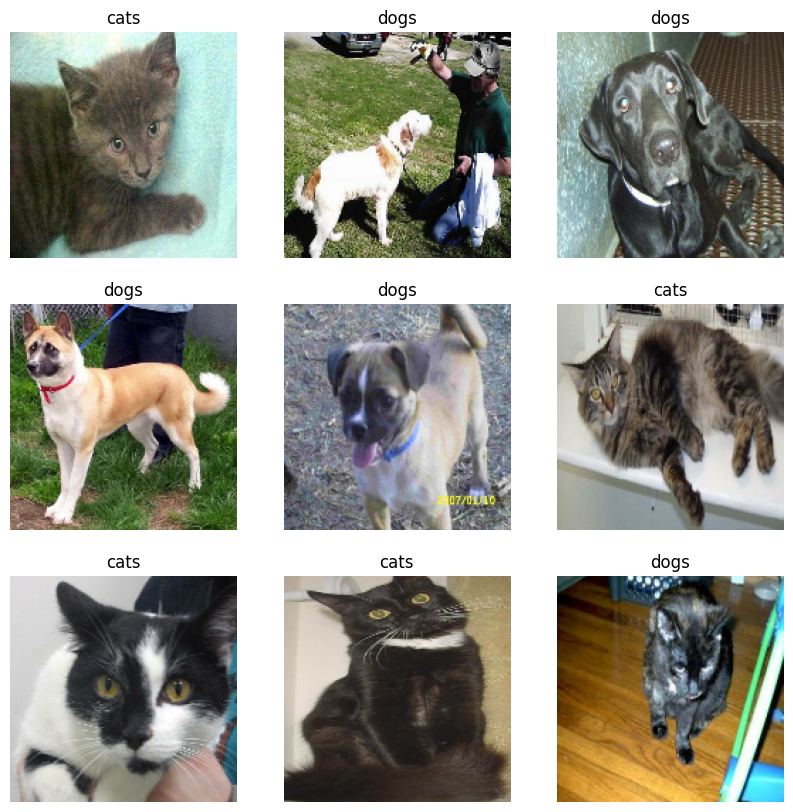

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [ ]:
# Save the model
model_name = "cat-dog-tuned"
model.save(model_name)